In [135]:
# BEFORE DOING ANYTHING
# cd Desktop
# git pull

# .. then do stuff ..
# git add .
# git commit -m "your message"
# git push


import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [136]:
# The top 10 most important features are:
# How many people the property accommodates
# The cleaning fee
# How many other listings the host has (and whether they are a multi-listing host)
# How many days are available to book out of the next 90
# The fee per extra person
# The number of reviews
# The number of bathrooms
# The security deposit
# If the property is in Westminster
# The minimum nights stay


raw_df = pd.read_csv("listings.csv.gz")
# free text columns will be dropped for now
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)

In [137]:
df.isna().sum()
df.drop(["host_acceptance_rate", "neighbourhood_group_cleansed", "square_feet", "weekly_price", "monthly_price", 
         "license", "jurisdiction_names"], axis=1, inplace=True)

In [138]:
# host_listings_count and host_total_listings_count are the same in all but 16 cases. 
# These cases are those where the value is NaN. Therefore one of these columns can be dropped. 
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:]
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)


16


In [139]:
# Since all locations in Los Angeles, drop any columns related to location ie state, country
df["smart_location"].value_counts()
lat_long = df[["latitude", "longitude"]]
df.drop(["zipcode", "state", "country", "country_code", "street", "neighbourhood", "city", "latitude", "longitude", 
         "market", "smart_location", "is_location_exact"], axis=1, inplace= True)

In [140]:
# There are multiple columns for minimum and maximum night stays, 
# but the two main ones will be used as there are few differences between e.g. minimum_nights 
# and minimum_minimum_nights. The default (i.e. most frequently applied) min/max night stay values will be used instead.
sum((df.minimum_nights == df.minimum_minimum_nights) == False)
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], 
          axis=1, inplace=True)

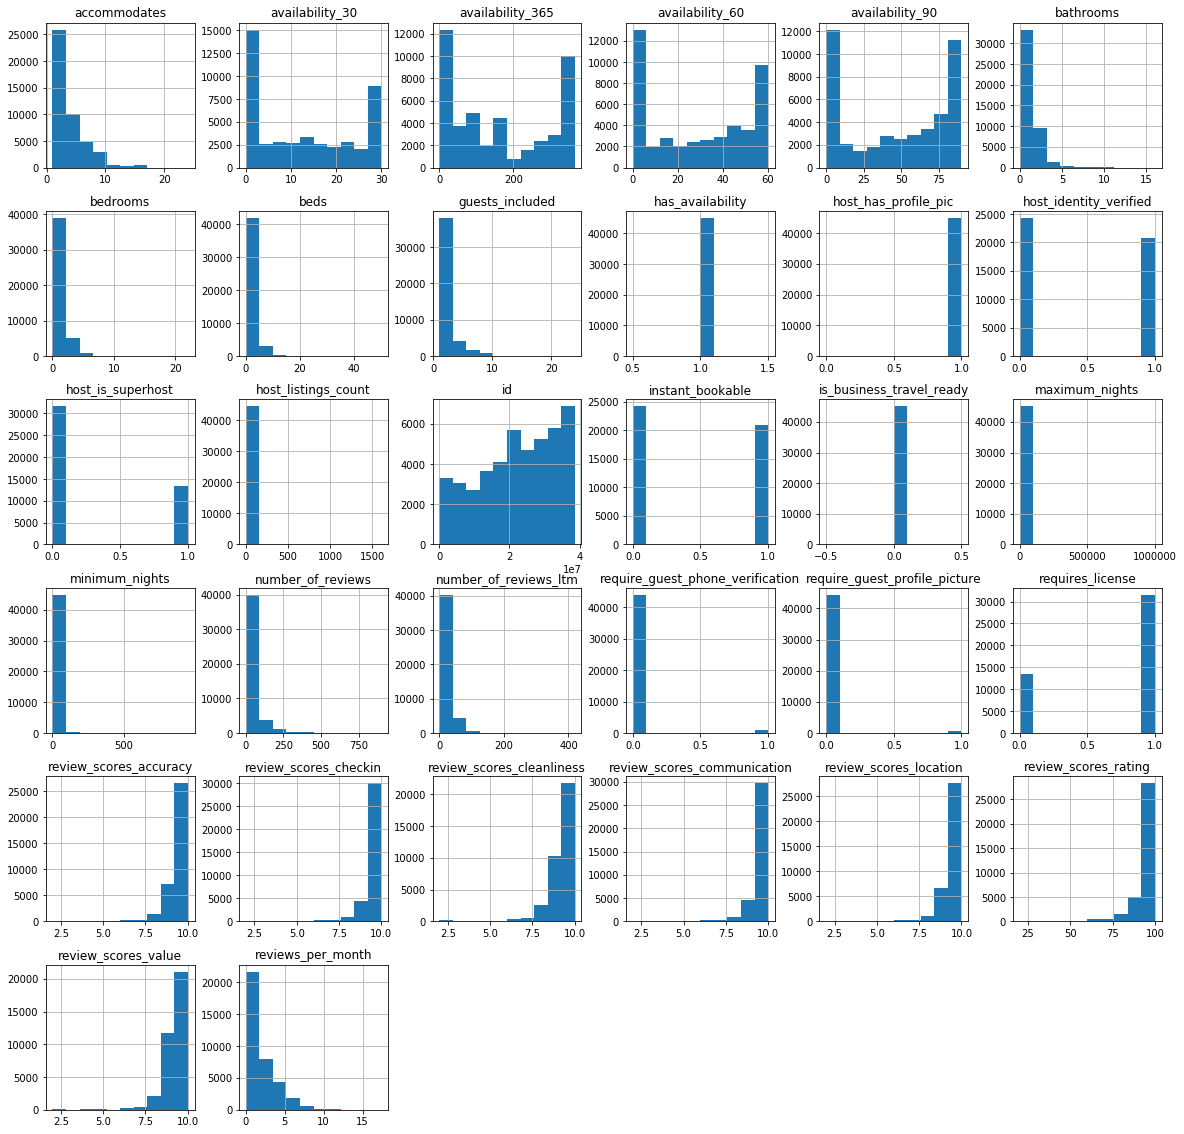

In [141]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [142]:
# Can see above that some boolean categories only contain one category and can be dropped:
df.drop(['has_availability', 'host_has_profile_pic', 'host_listings_count', 'is_business_travel_ready'], axis=1, inplace=True)

In [143]:
# Drop experiences_offered, 
print(df['experiences_offered'].value_counts())
df.drop('experiences_offered', axis=1, inplace=True)

none    45053
Name: experiences_offered, dtype: int64


In [144]:
# Now we're at 44 columns
print(df.shape)

(45053, 44)


In [145]:
###############################
## CLEANING INDIVIDUAL COLS ###
###############################

# host_since
# Converting to date time
df.host_since = pd.to_datetime(df.host_since)

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)


Mean days as host: 1290.0
Median days as host: 1259.0


In [146]:
# host_response_time

print("Null values:", df.host_response_time.isna().sum())

prop = round((df.host_response_time.isna().sum()/len(df))*100, 1)
print(f"Proportion: {prop}%")

# Number of rows without a value for host_response_time which have also not yet had a review
print(len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2]))

df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)


Null values: 8294
Proportion: 18.4%
8519


within an hour        0.600293
unknown               0.184094
within a few hours    0.120392
within a day          0.073513
a few days or more    0.021708
Name: host_response_time, dtype: float64

In [147]:
# host_response_rate
df.host_response_rate.value_counts()
print("Null values:", df.host_response_rate.isna().sum())
prop = round((df.host_response_rate.isna().sum()/len(df))*100, 1)
print(f"Proportion: {prop}%")


# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
prop_hund = round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)
print(f"Proportion of 100% host response rates: {prop_hund}%")

Null values: 8294
Proportion: 18.4%
Mean host response rate: 94.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.0%


In [148]:
# Bin into 4 categories 
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       25726
unknown     8294
90-99%      5118
50-89%      4566
0-49%       1349
Name: host_response_rate, dtype: int64

In [149]:
# host_is_superhost

df.host_is_superhost.value_counts()

# There are 16 rows lacking values for each of five different host-related features.
# These rows will be dropped 
df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 
                  'host_identity_verified'] ].isnull().sum(axis=1) == 5]

df.dropna(subset=['host_since'], inplace=True)

In [150]:
# property_type

# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

df.property_type.value_counts()

House        19390
Apartment    17872
Other         7775
Name: property_type, dtype: int64

In [151]:
# beds, bathrooms, bedrooms

# Replace missing values with the median
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)
    
# most listings have the same bed_type, so drop this
df.bed_type.value_counts()

df.drop('bed_type', axis=1, inplace=True)

In [152]:
# Amenities is a list of additional features in the property, e.g. whether it has a TV or parking.

# Create a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air hockey table',
 'Air purifier',
 'Alarm system',
 'Alfresco bathtub',
 'Alfresco shower',
 'Amazon Echo',
 'Apple TV',
 'BBQ grill',
 'Baby bath',
 'Baby equipment',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bar',
 'Basketball court',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach chairs',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bicycle',
 'Bidet',
 'Boat',
 'Body soap',
 'Boogie boards',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Brick oven',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Canoe',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling fans',
 'Ceiling hoist',
 'Central air conditioning',
 'Changing table',
 'Charcoal barbeque',
 "Chef's kitchen",
 "Children's toys",
 'Children’s books and toys',
 'Children’s dinnerware

In [153]:
# 44 cols to begin with
print(df.shape)

# Some amenities are more important than others, make new features for these (One Hot Encoding)
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

(45037, 44)


In [158]:
# Start at 44 because cols 44 thru 72 are the new amenity features

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,44:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,44:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

(45037, 72)
['check_in_24h', 'high_end_electronics', 'nature_and_views', 'smoking_allowed', 'accessible', 'event_suitable']


In [159]:
df

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in
0,109,2008-06-27,unknown,unknown,0.0,1.0,Culver City,Other,Entire home/apt,6,2.0,2.0,3.0,$122.00,$500.00,$240.00,3,$25.00,30,730,7 months ago,0,0,0,165,2,0,2011-08-15,2016-05-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,0,0,strict_14_with_grace_period,1,0,0.02,3938.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,344,2008-07-11,within a day,0-49%,0.0,1.0,Burbank,House,Entire home/apt,6,1.0,3.0,3.0,$168.00,$0.00,$100.00,6,$0.00,2,14,7 weeks ago,0,0,0,0,6,1,2016-06-14,2018-10-21,93.0,10.0,10.0,10.0,10.0,10.0,9.0,0,1,flexible,0,0,0.15,3924.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2708,2008-09-16,within an hour,100%,1.0,1.0,Hollywood,Apartment,Private room,1,1.5,1.0,1.0,$79.00,$480.00,$87.00,1,$0.00,28,366,4 months ago,0,0,1,276,21,8,2014-06-09,2019-08-03,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,strict_14_with_grace_period,0,0,0.33,3857.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2732,2008-09-17,within an hour,100%,1.0,0.0,Santa Monica,Apartment,Private room,1,1.0,1.0,1.0,$140.00,NaN,$100.00,1,$0.00,1,180,8 months ago,11,41,71,346,19,2,2011-06-06,2019-08-03,96.0,9.0,9.0,10.0,10.0,10.0,9.0,1,0,strict_14_with_grace_period,0,0,0.19,3856.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2864,2008-09-25,unknown,unknown,0.0,1.0,Bellflower,Apartment,Entire home/apt,2,1.0,1.0,1.0,$80.00,$100.00,$75.00,1,$25.00,2,730,14 months ago,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,strict_14_with_grace_period,0,0,NaN,3848.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45048,38603385,2018-04-14,unknown,unknown,0.0,0.0,Reseda,House,Private room,1,1.0,0.0,1.0,$89.00,NaN,NaN,1,$0.00,1,1125,today,23,53,83,173,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,flexible,0,0,NaN,360.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
45049,38603626,2016-08-15,within an hour,100%,1.0,1.0,Sun Valley,Apartment,Private room,2,1.0,1.0,1.0,$90.00,NaN,$25.00,1,$0.00,3,1125,today,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,flexible,0,0,NaN,967.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
45050,38603645,2015-03-22,unknown,unknown,0.0,0.0,Pasadena,House,Private room,2,1.0,1.0,2.0,$47.00,NaN,NaN,1,$0.00,1,1125,today,12,42,72,347,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,flexible,0,0,NaN,1479.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
45051,38604183,2016-01-16,within an hour,90-99%,0.0,0.0,Venice,Apartment,Entire home/apt,3,1.0,1.0,1.0,$105.00,$500.00,$115.00,1,$0.00,30,1125,today,1